In [11]:
import numpy as np
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from sklearn.utils import resample
from sklearn.metrics import pairwise
from timerun import time_code, time_func
import time
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from parallel_methods import DSMethods
import pandas as pd
from sklearn import preprocessing

In [12]:
def plot_train_vs_test(train_scores, test_scores, spoint = None, wo = None, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    
    xleft, xright = plt.xlim()
    if spoint and wo:
        plt.scatter(spoint[0], spoint[1], s=10, c='red')
        w = [-wo[1]/n_features, wo[0]]
        b = w[0]*spoint[0] + w[1]*spoint[1]
        xleft, xright = plt.xlim()
        xd = np.array([xleft, xright])
        yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
        plt.plot(xd, yd, lw=1, c='red')
    
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)

def scal(data, w):
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    spoint_x = list(data.keys())[np.argmin(obj)]
    spoint_y = data[spoint_x]
    return (spoint_x, spoint_y, obj[np.argmin(obj)])

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

In [3]:
n_features = 500

# Load the madelon training dataset
train_data = pd.read_table("MADELON/madelon_train.data", sep=' ', header=None, usecols=range(0,500))
train_labels = pd.read_table("MADELON/madelon_train.labels", sep=' ', header=None)
X_train, X_test = np.split(preprocessing.scale(train_data.to_numpy()), [1200])
y_train, y_test = np.split(np.ravel(train_labels.to_numpy()), [1200])

data = DSMethods(n_features, X_train, y_train, X_test, y_test)

# Lineal vs. Non-Lineal

In [14]:
@time_func
def RANDOM_SELECTION(CVal = 0.1, kernel='liblinear'):
    data.kernel = kernel
    with Pool(6) as pool:
        scores = pool.map(data.randomSelection, [CVal]*10)
    
    #scores = list(map(data.randomSelection, [0.1]))

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    time         = np.mean([x[2] for x in scores])
    plot_train_vs_test(train_scores, test_scores)

In [38]:
#RANDOM_SELECTION()
#RANDOM_SELECTION(kernel='linear')

#data.kernel_matrix = 'poly'
#RANDOM_SELECTION(kernel='precomputed')

#data.kernel_matrix = None
#RANDOM_SELECTION(kernel='poly')

# SVM

In [15]:
@time_func
def SVM_RFE_W_STEP(step, C = 0.5, degree = 3, kernel = 'linear', w1 = [0.8, 0.2]):
    data.kernel = 'precomputed'
    data.kernel_matrix = kernel
    data.C = C
    data.degree = degree
    kf = KFold(n_splits=6, shuffle=True)

    index = [(train_index, test_index, step) for train_index, test_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe_kernel, index)

    #scores = list(map(data.svm_rfe_kernel, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])

    print(kernel, degree, C)
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)
    

poly 1 0.1


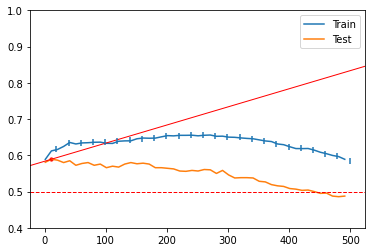

AT (11, 0.5891666666666666, 0.33306666666666673) WITH 25 ITERATIONS IN 346.9683960676193 SECONDS : 178.20084794467925
__main__.SVM_RFE_W_STEP - 00:06:01.039083400
poly 1 0.2


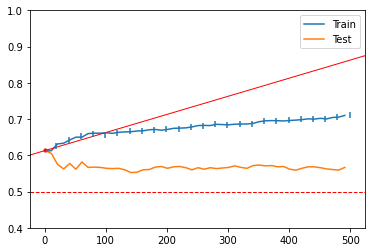

AT (1, 0.6133333333333333, 0.3097333333333334) WITH 25 ITERATIONS IN 357.2688692808151 SECONDS : 81.13332001667975
__main__.SVM_RFE_W_STEP - 00:06:10.843064900
poly 1 0.3


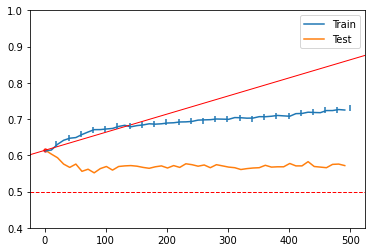

AT (1, 0.6141666666666666, 0.3090666666666667) WITH 25 ITERATIONS IN 349.687517285347 SECONDS : 178.44199966717815
__main__.SVM_RFE_W_STEP - 00:06:04.182446600
poly 1 0.4


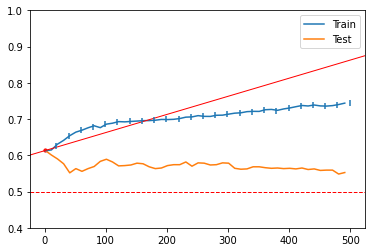

AT (1, 0.6133333333333333, 0.3097333333333334) WITH 25 ITERATIONS IN 354.6159352858861 SECONDS : 1513.0162576429286
__main__.SVM_RFE_W_STEP - 00:06:27.044555700
poly 1 0.5


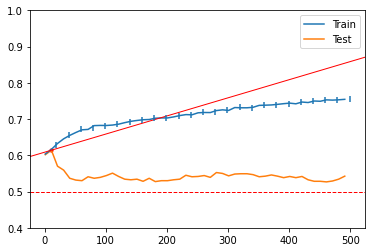

AT (11, 0.6141666666666667, 0.31306666666666666) WITH 25 ITERATIONS IN 349.7721930742264 SECONDS : 81.17854371910195
__main__.SVM_RFE_W_STEP - 00:06:03.375406500


In [40]:
SVM_RFE_W_STEP(20, 0.1, 1, 'poly')
SVM_RFE_W_STEP(20, 0.2, 1, 'poly')
SVM_RFE_W_STEP(20, 0.3, 1, 'poly')
SVM_RFE_W_STEP(20, 0.4, 1, 'poly')
SVM_RFE_W_STEP(20, 0.5, 1, 'poly')

poly 2 0.1


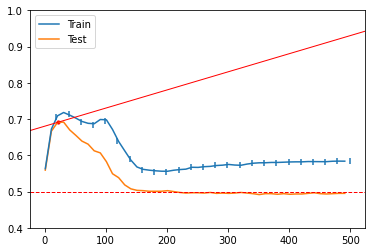

AT (21, 0.6908333333333334, 0.2557333333333333) WITH 25 ITERATIONS IN 150.06500339508057 SECONDS : 2.3655162533326197
__main__.SVM_RFE_W_STEP - 00:02:36.519281400
poly 2 0.2


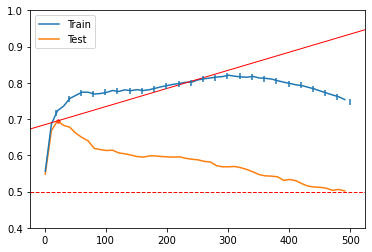

AT (21, 0.695, 0.25240000000000007) WITH 25 ITERATIONS IN 151.71135461330414 SECONDS : 2.9801713447190488
__main__.SVM_RFE_W_STEP - 00:02:38.874395400
poly 2 0.3


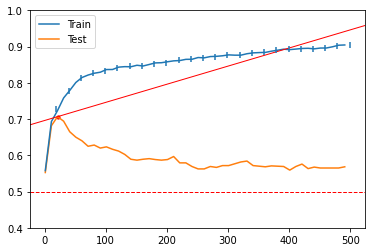

AT (21, 0.7066666666666667, 0.24306666666666668) WITH 25 ITERATIONS IN 150.58564925193787 SECONDS : 3.388716765010751
__main__.SVM_RFE_W_STEP - 00:02:37.261030400
__main__.SVM_RFE_W_STEP - 00:02:38.444023900


KeyboardInterrupt: 

In [6]:
SVM_RFE_W_STEP(20, 0.1, 2, 'poly')
SVM_RFE_W_STEP(20, 0.2, 2, 'poly')
SVM_RFE_W_STEP(20, 0.3, 2, 'poly')
SVM_RFE_W_STEP(20, 0.4, 2, 'poly')
SVM_RFE_W_STEP(20, 0.5, 2, 'poly')

poly 3 0.1


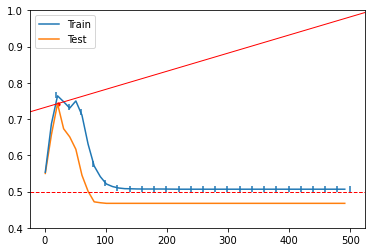

AT (21, 0.7425, 0.21439999999999995) WITH 25 ITERATIONS IN 428.76717670758563 SECONDS : 0.7603034539006835
__main__.SVM_RFE_W_STEP - 00:07:15.652571800
poly 3 0.2


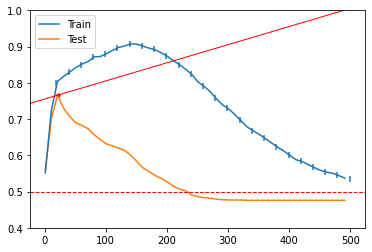

AT (21, 0.7658333333333335, 0.19573333333333323) WITH 25 ITERATIONS IN 426.5068008899689 SECONDS : 15.2699355008304
__main__.SVM_RFE_W_STEP - 00:07:15.134471900
poly 3 0.3


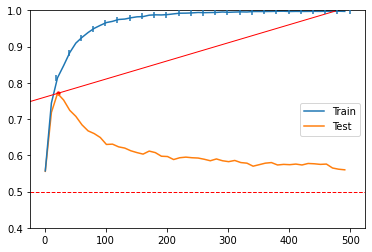

AT (21, 0.7708333333333334, 0.1917333333333333) WITH 25 ITERATIONS IN 425.02843077977496 SECONDS : 2.603976611712287
__main__.SVM_RFE_W_STEP - 00:07:12.246887300
poly 3 0.4


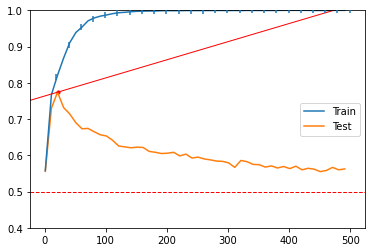

AT (21, 0.7741666666666666, 0.18906666666666674) WITH 25 ITERATIONS IN 425.4498623609543 SECONDS : 14.166443673548557
__main__.SVM_RFE_W_STEP - 00:07:14.165989100
poly 3 0.5


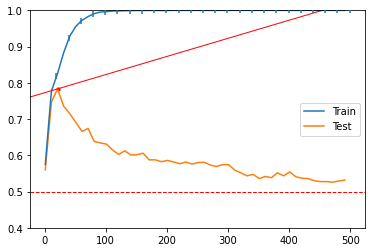

AT (21, 0.7833333333333333, 0.18173333333333333) WITH 25 ITERATIONS IN 424.99713742733 SECONDS : 16.76633951351349
__main__.SVM_RFE_W_STEP - 00:07:14.211228000


In [42]:
SVM_RFE_W_STEP(20, 0.1, 3, 'poly')
SVM_RFE_W_STEP(20, 0.2, 3, 'poly')
SVM_RFE_W_STEP(20, 0.3, 3, 'poly')
SVM_RFE_W_STEP(20, 0.4, 3, 'poly')
SVM_RFE_W_STEP(20, 0.5, 3, 'poly')

poly 4 0.1


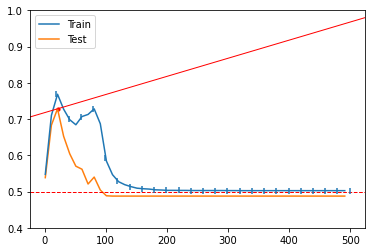

AT (21, 0.7283333333333334, 0.22573333333333329) WITH 25 ITERATIONS IN 422.29635258515674 SECONDS : 2.114215420579653
__main__.SVM_RFE_W_STEP - 00:07:09.247637900
poly 4 0.2


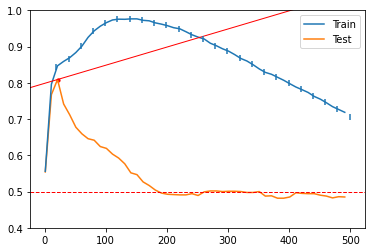

AT (21, 0.8091666666666666, 0.16106666666666672) WITH 25 ITERATIONS IN 418.92885907491046 SECONDS : 1.6929201828884606
__main__.SVM_RFE_W_STEP - 00:07:05.786856100
poly 4 0.3


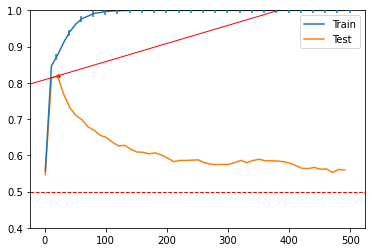

AT (21, 0.8191666666666667, 0.15306666666666663) WITH 25 ITERATIONS IN 418.7412431240082 SECONDS : 0.46976674058765866
__main__.SVM_RFE_W_STEP - 00:07:05.593798400
poly 4 0.4


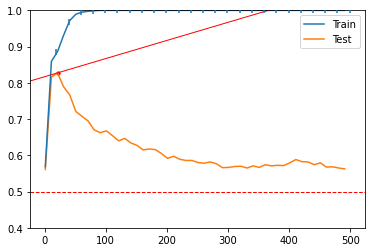

AT (21, 0.8275, 0.14639999999999997) WITH 25 ITERATIONS IN 417.7435766061147 SECONDS : 1.1853915686732093
__main__.SVM_RFE_W_STEP - 00:07:04.890142400
poly 4 0.5


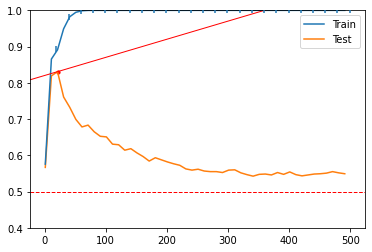

AT (21, 0.8308333333333334, 0.14373333333333327) WITH 25 ITERATIONS IN 418.62632286548615 SECONDS : 1.9139504816395885
__main__.SVM_RFE_W_STEP - 00:07:05.922867200


In [43]:
SVM_RFE_W_STEP(20, 0.1, 4, 'poly')
SVM_RFE_W_STEP(20, 0.2, 4, 'poly')
SVM_RFE_W_STEP(20, 0.3, 4, 'poly')
SVM_RFE_W_STEP(20, 0.4, 4, 'poly')
SVM_RFE_W_STEP(20, 0.5, 4, 'poly')

poly 5 0.1


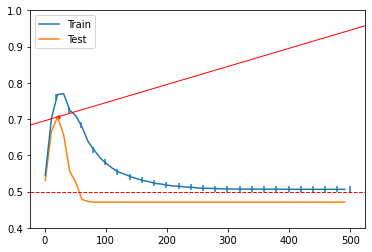

AT (21, 0.7058333333333334, 0.24373333333333327) WITH 25 ITERATIONS IN 422.02044451236725 SECONDS : 13.928225770032626
__main__.SVM_RFE_W_STEP - 00:07:10.027751900
poly 5 0.2


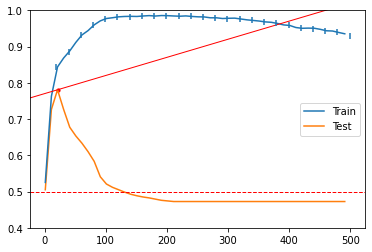

AT (21, 0.7808333333333334, 0.1837333333333333) WITH 25 ITERATIONS IN 418.6075192292531 SECONDS : 0.6246409298652351
__main__.SVM_RFE_W_STEP - 00:07:05.248957100
poly 5 0.3


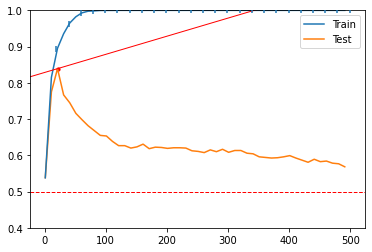

AT (21, 0.8391666666666667, 0.13706666666666661) WITH 25 ITERATIONS IN 418.81849626700085 SECONDS : 0.6121985065124403
__main__.SVM_RFE_W_STEP - 00:07:05.726722300
poly 5 0.4


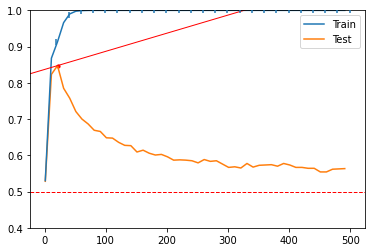

AT (21, 0.8475000000000001, 0.13039999999999988) WITH 25 ITERATIONS IN 419.0036395788193 SECONDS : 11.841837692951605
__main__.SVM_RFE_W_STEP - 00:07:07.630920900
poly 5 0.5


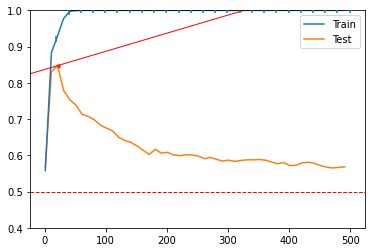

AT (21, 0.8475, 0.1304) WITH 25 ITERATIONS IN 417.7529796361923 SECONDS : 1.331402784335405
__main__.SVM_RFE_W_STEP - 00:07:04.913704100


In [44]:
SVM_RFE_W_STEP(20, 0.1, 5, 'poly')
SVM_RFE_W_STEP(20, 0.2, 5, 'poly')
SVM_RFE_W_STEP(20, 0.3, 5, 'poly')
SVM_RFE_W_STEP(20, 0.4, 5, 'poly')
SVM_RFE_W_STEP(20, 0.5, 5, 'poly')

poly 6 0.1


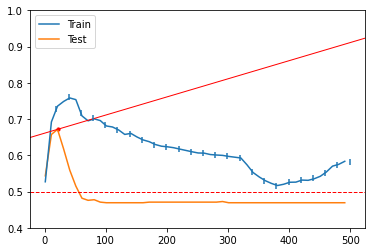

AT (21, 0.6716666666666667, 0.2710666666666666) WITH 25 ITERATIONS IN 421.1676253080368 SECONDS : 1.1545669624282435
__main__.SVM_RFE_W_STEP - 00:07:08.199351100
poly 6 0.2


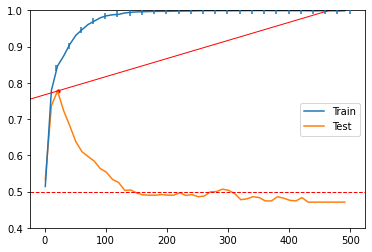

AT (21, 0.7775, 0.18640000000000004) WITH 25 ITERATIONS IN 421.64982438087463 SECONDS : 1.7296175108858545
__main__.SVM_RFE_W_STEP - 00:07:08.713217100
poly 6 0.3


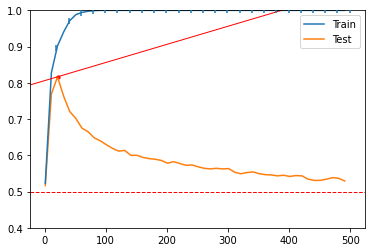

AT (21, 0.8166666666666665, 0.15506666666666677) WITH 25 ITERATIONS IN 418.5221191247304 SECONDS : 1.5555609910048183
__main__.SVM_RFE_W_STEP - 00:07:05.896288600
poly 6 0.4


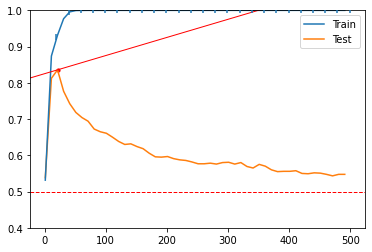

AT (21, 0.8358333333333333, 0.13973333333333335) WITH 25 ITERATIONS IN 419.07114168008167 SECONDS : 11.062652302917408
__main__.SVM_RFE_W_STEP - 00:07:07.355734600
poly 6 0.5


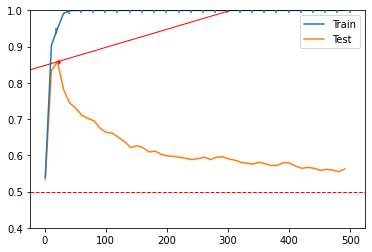

AT (21, 0.8583333333333334, 0.12173333333333329) WITH 25 ITERATIONS IN 419.72824164231616 SECONDS : 1.126008142004355
__main__.SVM_RFE_W_STEP - 00:07:06.857788500


In [45]:
SVM_RFE_W_STEP(20, 0.1, 6, 'poly')
SVM_RFE_W_STEP(20, 0.2, 6, 'poly')
SVM_RFE_W_STEP(20, 0.3, 6, 'poly')
SVM_RFE_W_STEP(20, 0.4, 6, 'poly')
SVM_RFE_W_STEP(20, 0.5, 6, 'poly')

poly 7 0.1


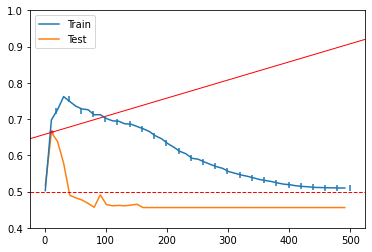

AT (11, 0.6633333333333333, 0.2737333333333334) WITH 25 ITERATIONS IN 423.15392259756726 SECONDS : 16.27478908305061
__main__.SVM_RFE_W_STEP - 00:07:11.565200800
poly 7 0.2


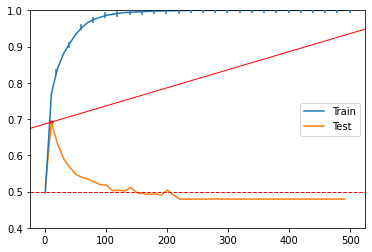

AT (11, 0.6916666666666665, 0.25106666666666677) WITH 25 ITERATIONS IN 419.11664434274036 SECONDS : 0.7651175501502966
__main__.SVM_RFE_W_STEP - 00:07:06.018158000
poly 7 0.3


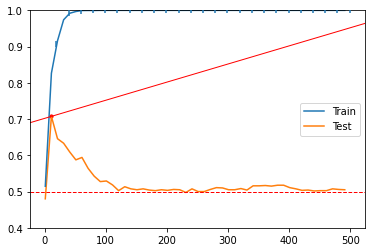

AT (11, 0.7075, 0.23839999999999997) WITH 25 ITERATIONS IN 418.236071228981 SECONDS : 0.7573241341803273
__main__.SVM_RFE_W_STEP - 00:07:05.370275600
poly 7 0.4


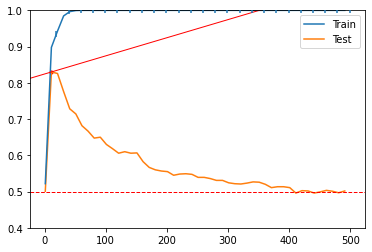

AT (11, 0.83, 0.14040000000000002) WITH 25 ITERATIONS IN 418.4634744326274 SECONDS : 0.907603841022112
__main__.SVM_RFE_W_STEP - 00:07:05.685752600
poly 7 0.5


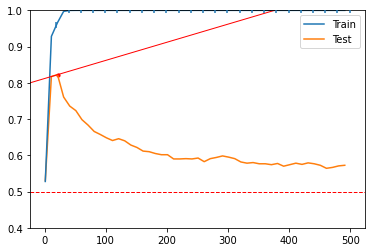

AT (21, 0.8225000000000001, 0.1503999999999999) WITH 25 ITERATIONS IN 417.3743662436803 SECONDS : 0.342758247693409
__main__.SVM_RFE_W_STEP - 00:07:04.305472600


In [46]:
SVM_RFE_W_STEP(20, 0.1, 7, 'poly')
SVM_RFE_W_STEP(20, 0.2, 7, 'poly')
SVM_RFE_W_STEP(20, 0.3, 7, 'poly')
SVM_RFE_W_STEP(20, 0.4, 7, 'poly')
SVM_RFE_W_STEP(20, 0.5, 7, 'poly')

poly 8 0.1


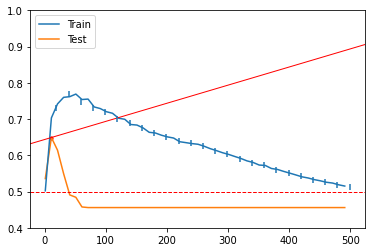

AT (11, 0.6491666666666667, 0.2850666666666667) WITH 25 ITERATIONS IN 421.21133625507355 SECONDS : 1.7752350753414465
__main__.SVM_RFE_W_STEP - 00:07:08.367004500
poly 8 0.2


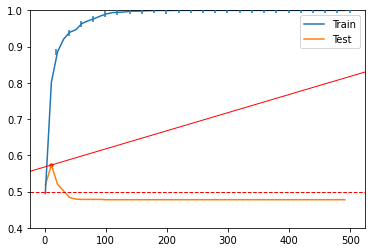

AT (11, 0.5733333333333334, 0.34573333333333334) WITH 25 ITERATIONS IN 419.22165580590564 SECONDS : 1.6474329453367773
__main__.SVM_RFE_W_STEP - 00:07:06.168235700
poly 8 0.3


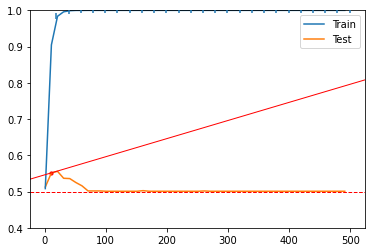

AT (11, 0.5516666666666666, 0.3630666666666667) WITH 25 ITERATIONS IN 418.55767250061035 SECONDS : 0.2794124905090977
__main__.SVM_RFE_W_STEP - 00:07:05.419790900
poly 8 0.4


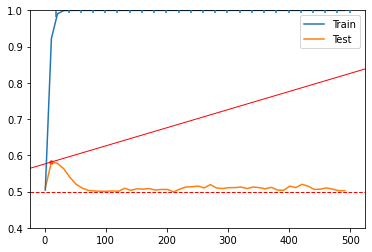

AT (11, 0.5816666666666667, 0.3390666666666667) WITH 25 ITERATIONS IN 418.1775212287903 SECONDS : 1.3571485205720062
__main__.SVM_RFE_W_STEP - 00:07:07.274650800
poly 8 0.5


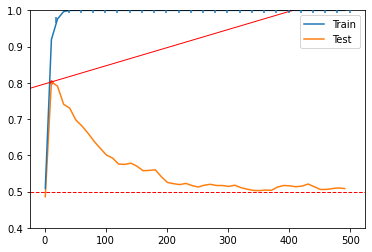

AT (11, 0.8024999999999999, 0.1624000000000001) WITH 25 ITERATIONS IN 417.9515149593353 SECONDS : 1.1351604593749205
__main__.SVM_RFE_W_STEP - 00:07:05.191928800


In [47]:
SVM_RFE_W_STEP(20, 0.1, 8, 'poly')
SVM_RFE_W_STEP(20, 0.2, 8, 'poly')
SVM_RFE_W_STEP(20, 0.3, 8, 'poly')
SVM_RFE_W_STEP(20, 0.4, 8, 'poly')
SVM_RFE_W_STEP(20, 0.5, 8, 'poly')

poly 1 0.6


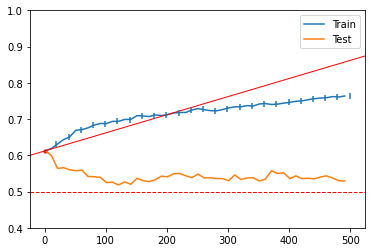

AT (1, 0.6124999999999999, 0.31040000000000006) WITH 25 ITERATIONS IN 341.3159730831782 SECONDS : 22.411972553221773
__main__.SVM_RFE_W_STEP - 00:05:50.962914800
poly 2 0.6


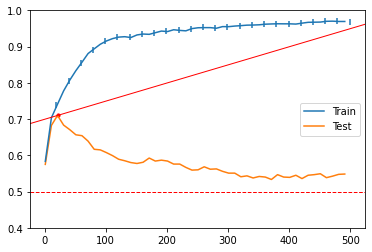

AT (21, 0.71, 0.24040000000000003) WITH 25 ITERATIONS IN 347.57948716481525 SECONDS : 65.91675571424813
__main__.SVM_RFE_W_STEP - 00:06:00.244734700
poly 3 0.6


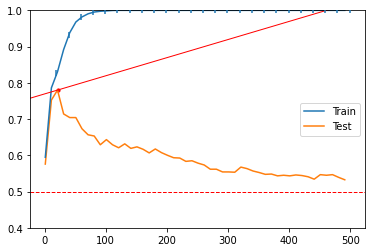

AT (21, 0.7800000000000001, 0.1843999999999999) WITH 25 ITERATIONS IN 450.24011023839313 SECONDS : 0.06068703601940545
__main__.SVM_RFE_W_STEP - 00:07:37.378764000
poly 4 0.6


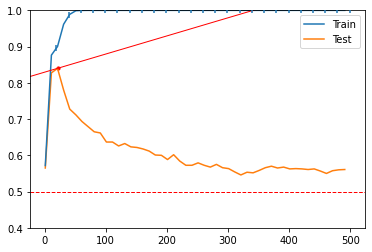

AT (21, 0.84, 0.13640000000000002) WITH 25 ITERATIONS IN 448.83433735370636 SECONDS : 13.028437961418959
__main__.SVM_RFE_W_STEP - 00:07:38.490896300
poly 5 0.6


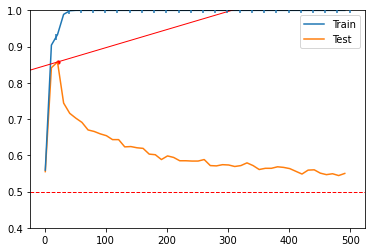

AT (21, 0.8574999999999999, 0.12240000000000006) WITH 25 ITERATIONS IN 450.8701198498408 SECONDS : 0.2418135332884961
__main__.SVM_RFE_W_STEP - 00:07:38.060155000
poly 6 0.6


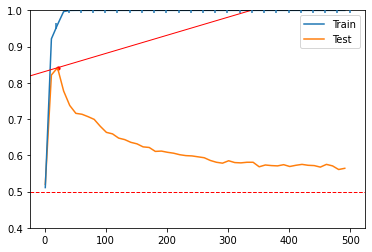

AT (21, 0.8416666666666668, 0.13506666666666656) WITH 25 ITERATIONS IN 451.94083046913147 SECONDS : 9.314943355664903
__main__.SVM_RFE_W_STEP - 00:07:41.133802300
poly 7 0.6


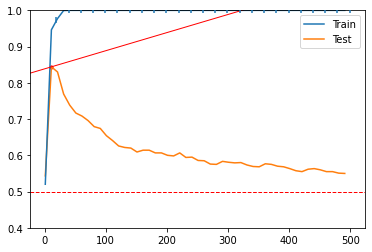

AT (11, 0.8441666666666666, 0.1290666666666667) WITH 25 ITERATIONS IN 457.97156568368274 SECONDS : 21.626779642511476
__main__.SVM_RFE_W_STEP - 00:07:48.516115500
poly 8 0.6


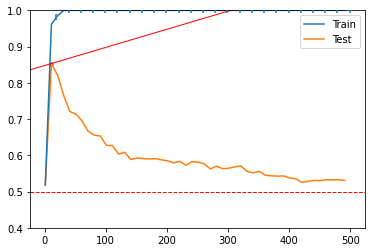

AT (11, 0.8533333333333335, 0.12173333333333321) WITH 25 ITERATIONS IN 451.1135111649831 SECONDS : 0.23840427273326112
__main__.SVM_RFE_W_STEP - 00:07:38.407739900


In [48]:
SVM_RFE_W_STEP(20, 0.6, 1, 'poly')
SVM_RFE_W_STEP(20, 0.6, 2, 'poly')
SVM_RFE_W_STEP(20, 0.6, 3, 'poly')
SVM_RFE_W_STEP(20, 0.6, 4, 'poly')
SVM_RFE_W_STEP(20, 0.6, 5, 'poly')
SVM_RFE_W_STEP(20, 0.6, 6, 'poly')
SVM_RFE_W_STEP(20, 0.6, 7, 'poly')
SVM_RFE_W_STEP(20, 0.6, 8, 'poly')

poly 1 0.7


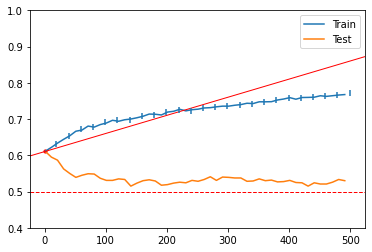

AT (1, 0.6108333333333333, 0.31173333333333336) WITH 25 ITERATIONS IN 340.31107060114545 SECONDS : 30.866873044698362
__main__.SVM_RFE_W_STEP - 00:05:50.254180200
poly 2 0.7


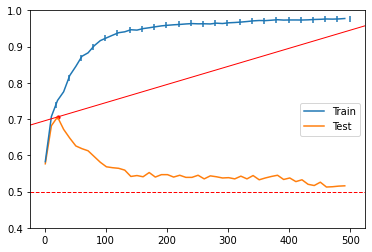

AT (21, 0.7058333333333334, 0.24373333333333327) WITH 25 ITERATIONS IN 341.6748844385147 SECONDS : 26.541599571889844
__main__.SVM_RFE_W_STEP - 00:05:51.694934000
poly 3 0.7


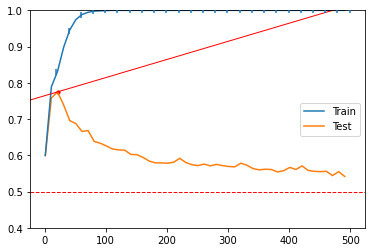

AT (21, 0.775, 0.18839999999999998) WITH 25 ITERATIONS IN 452.0553919474284 SECONDS : 11.547566052145283
__main__.SVM_RFE_W_STEP - 00:07:41.670095900
poly 4 0.7


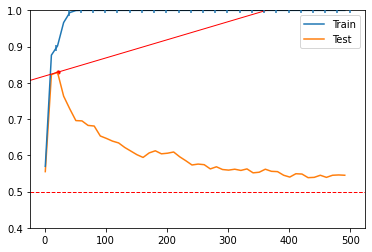

AT (21, 0.8291666666666666, 0.1450666666666667) WITH 25 ITERATIONS IN 453.07356309890747 SECONDS : 0.2850612836085323
__main__.SVM_RFE_W_STEP - 00:07:41.032519300
poly 5 0.7


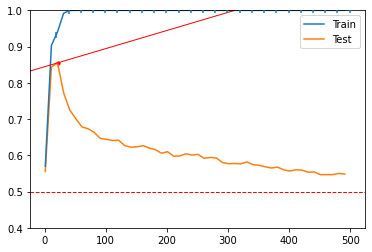

AT (21, 0.855, 0.12440000000000002) WITH 25 ITERATIONS IN 447.62914494673413 SECONDS : 11.734703913947222
__main__.SVM_RFE_W_STEP - 00:07:37.020815600
poly 6 0.7


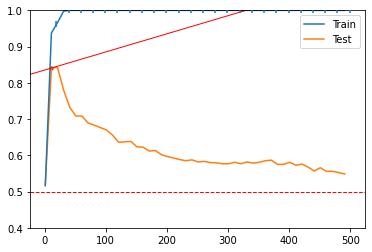

AT (11, 0.8408333333333333, 0.13173333333333334) WITH 25 ITERATIONS IN 455.36931876341504 SECONDS : 74.91940807591175
__main__.SVM_RFE_W_STEP - 00:07:48.193025500
poly 7 0.7


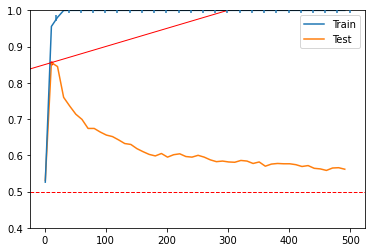

AT (11, 0.8558333333333333, 0.11973333333333334) WITH 25 ITERATIONS IN 444.8645555973053 SECONDS : 8.587434040015902
__main__.SVM_RFE_W_STEP - 00:07:33.502300900
poly 8 0.7


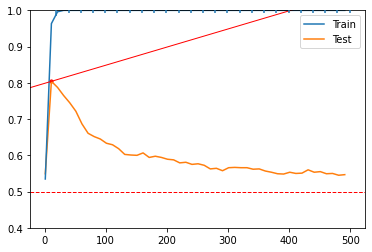

AT (11, 0.8041666666666666, 0.16106666666666672) WITH 25 ITERATIONS IN 431.88523054122925 SECONDS : 1.8019270322483483
__main__.SVM_RFE_W_STEP - 00:07:19.756207500


In [49]:
SVM_RFE_W_STEP(20, 0.7, 1, 'poly')
SVM_RFE_W_STEP(20, 0.7, 2, 'poly')
SVM_RFE_W_STEP(20, 0.7, 3, 'poly')
SVM_RFE_W_STEP(20, 0.7, 4, 'poly')
SVM_RFE_W_STEP(20, 0.7, 5, 'poly')
SVM_RFE_W_STEP(20, 0.7, 6, 'poly')
SVM_RFE_W_STEP(20, 0.7, 7, 'poly')
SVM_RFE_W_STEP(20, 0.7, 8, 'poly')

poly 1 0.8


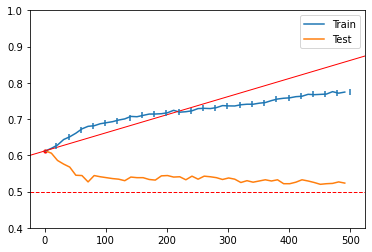

AT (1, 0.6124999999999999, 0.31040000000000006) WITH 25 ITERATIONS IN 344.3898712793986 SECONDS : 176.41780408355774
__main__.SVM_RFE_W_STEP - 00:05:58.665250600
poly 2 0.8


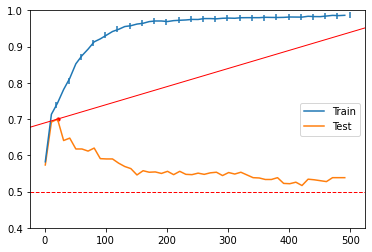

AT (21, 0.7000000000000001, 0.24839999999999995) WITH 25 ITERATIONS IN 346.31248354911804 SECONDS : 32.21547641207186
__main__.SVM_RFE_W_STEP - 00:05:56.592958300
poly 3 0.8


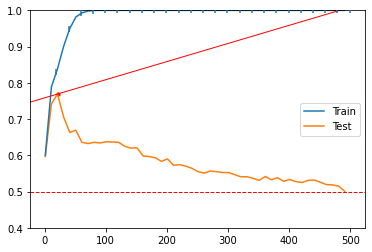

AT (21, 0.7691666666666667, 0.19306666666666666) WITH 25 ITERATIONS IN 441.9145066340764 SECONDS : 1.278200237586047
__main__.SVM_RFE_W_STEP - 00:07:29.896625300
poly 4 0.8


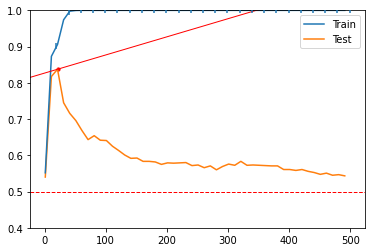

AT (21, 0.8375, 0.13839999999999997) WITH 25 ITERATIONS IN 447.84317835172016 SECONDS : 8.06109916858921
__main__.SVM_RFE_W_STEP - 00:07:36.727855600
poly 5 0.8


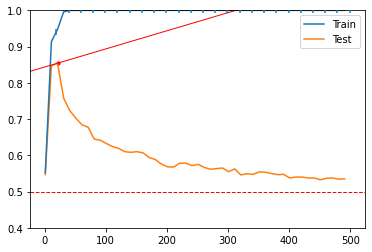

AT (21, 0.8541666666666665, 0.1250666666666668) WITH 25 ITERATIONS IN 448.3539994955063 SECONDS : 0.725793985450854
__main__.SVM_RFE_W_STEP - 00:07:35.893669700
poly 6 0.8


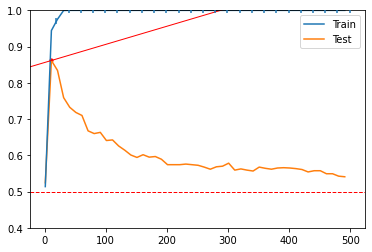

AT (11, 0.8616666666666667, 0.11506666666666665) WITH 25 ITERATIONS IN 451.4837869803111 SECONDS : 55.004146837117425
__main__.SVM_RFE_W_STEP - 00:07:42.918308000
poly 7 0.8


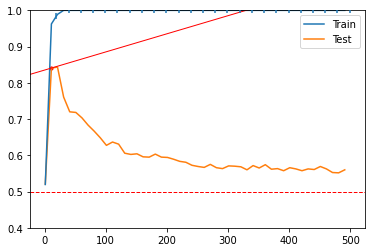

AT (11, 0.8408333333333333, 0.13173333333333334) WITH 25 ITERATIONS IN 445.9730642636617 SECONDS : 39.76107232343681
__main__.SVM_RFE_W_STEP - 00:07:36.508527800
poly 8 0.8


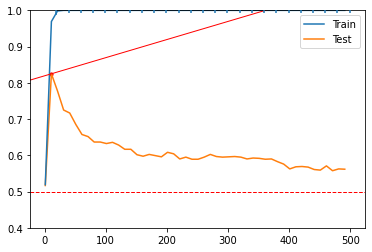

AT (11, 0.8249999999999998, 0.1444000000000001) WITH 25 ITERATIONS IN 440.33012696107227 SECONDS : 32.830803086161524
__main__.SVM_RFE_W_STEP - 00:07:30.445544200


In [50]:
SVM_RFE_W_STEP(20, 0.8, 1, 'poly')
SVM_RFE_W_STEP(20, 0.8, 2, 'poly')
SVM_RFE_W_STEP(20, 0.8, 3, 'poly')
SVM_RFE_W_STEP(20, 0.8, 4, 'poly')
SVM_RFE_W_STEP(20, 0.8, 5, 'poly')
SVM_RFE_W_STEP(20, 0.8, 6, 'poly')
SVM_RFE_W_STEP(20, 0.8, 7, 'poly')
SVM_RFE_W_STEP(20, 0.8, 8, 'poly')

# TODO
- Try with Poly-12, Poly-16 and Poly-32
- Try with Gaussian Kernel
- Try with Other Kernels
- Try with Dynamic Sampling (Poly)
- Try with Dynamic Step

poly 12 0.7


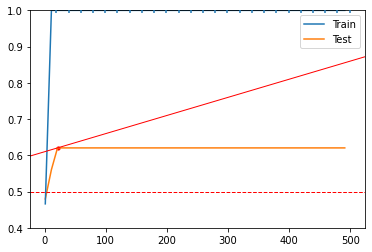

AT (21, 0.6204693998811646, 0.3120244800950684) WITH 25 ITERATIONS IN 17.153867920239765 SECONDS : 0.0705475597999986
__main__.SVM_RFE_W_STEP - 00:00:19.768174900
poly 12 0.8


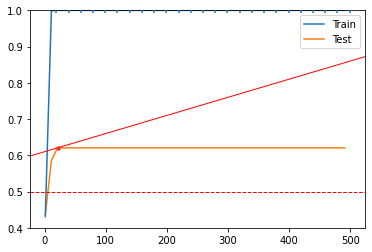

AT (21, 0.6206179441473559, 0.3119056446821153) WITH 25 ITERATIONS IN 18.032926241556805 SECONDS : 0.9284436343383821
__main__.SVM_RFE_W_STEP - 00:00:21.024276200
poly 12 0.9


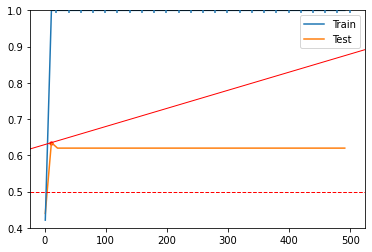

AT (11, 0.6350267379679144, 0.2963786096256685) WITH 25 ITERATIONS IN 18.53476123015086 SECONDS : 0.08326537363104415
__main__.SVM_RFE_W_STEP - 00:00:21.164811800


In [6]:
SVM_RFE_W_STEP(20, 0.7, 12, 'poly')
SVM_RFE_W_STEP(20, 0.8, 12, 'poly')
SVM_RFE_W_STEP(20, 0.9, 12, 'poly')

poly 1 0.9


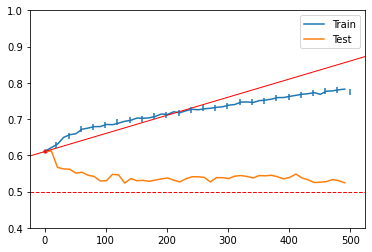

AT (1, 0.6108333333333335, 0.31173333333333325) WITH 25 ITERATIONS IN 347.8785475095113 SECONDS : 25.864684245031484
__main__.SVM_RFE_W_STEP - 00:05:57.371668400
poly 2 0.9


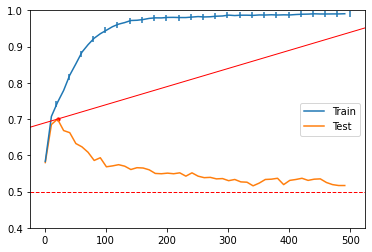

AT (21, 0.6999999999999998, 0.24840000000000012) WITH 25 ITERATIONS IN 342.00081074237823 SECONDS : 186.26399726870807
__main__.SVM_RFE_W_STEP - 00:05:57.039667700
poly 3 0.9


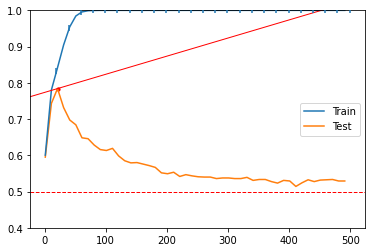

AT (21, 0.7841666666666667, 0.18106666666666665) WITH 25 ITERATIONS IN 446.8892813920975 SECONDS : 5.5468464330675475
__main__.SVM_RFE_W_STEP - 00:07:35.142351000
poly 4 0.9


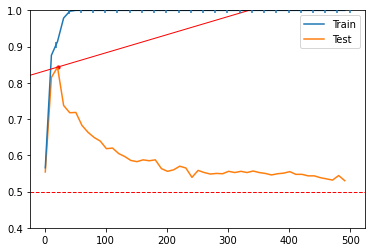

AT (21, 0.8433333333333333, 0.13373333333333337) WITH 25 ITERATIONS IN 437.13039950529736 SECONDS : 1.6726265470019712
__main__.SVM_RFE_W_STEP - 00:07:24.651497200
poly 5 0.9


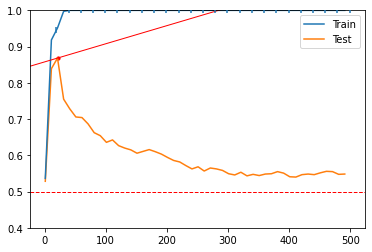

AT (21, 0.8683333333333332, 0.11373333333333346) WITH 25 ITERATIONS IN 439.19009300072986 SECONDS : 22.731559202217838
__main__.SVM_RFE_W_STEP - 00:07:28.883864100
poly 6 0.9


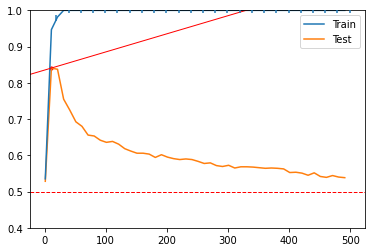

AT (11, 0.8408333333333333, 0.13173333333333334) WITH 25 ITERATIONS IN 446.53017115592957 SECONDS : 34.96107742813732
__main__.SVM_RFE_W_STEP - 00:07:37.186343000


In [8]:
SVM_RFE_W_STEP(20, 0.9, 1, 'poly')
SVM_RFE_W_STEP(20, 0.9, 2, 'poly')
SVM_RFE_W_STEP(20, 0.9, 3, 'poly')
SVM_RFE_W_STEP(20, 0.9, 4, 'poly')
SVM_RFE_W_STEP(20, 0.9, 5, 'poly')
SVM_RFE_W_STEP(20, 0.9, 6, 'poly')

poly 9 0.1


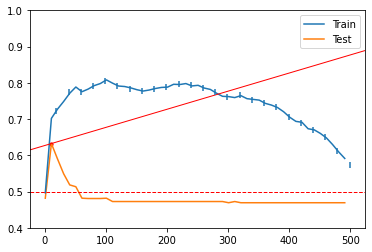

AT (11, 0.6325, 0.29840000000000005) WITH 25 ITERATIONS IN 455.7263703743617 SECONDS : 10.868993486059374
__main__.SVM_RFE_W_STEP - 00:07:44.930045800
poly 9 0.2


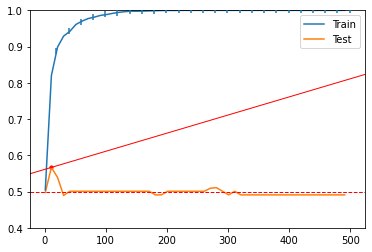

AT (11, 0.5666666666666667, 0.3510666666666667) WITH 25 ITERATIONS IN 460.34419310092926 SECONDS : 57.936003819472496
__main__.SVM_RFE_W_STEP - 00:07:52.295898500
poly 9 0.3


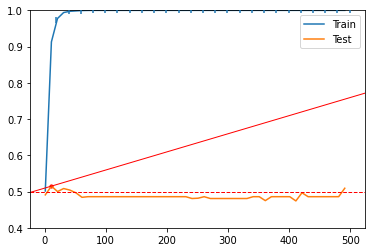

AT (11, 0.515, 0.3924) WITH 25 ITERATIONS IN 451.0132559935252 SECONDS : 4.843652466216738
__main__.SVM_RFE_W_STEP - 00:07:39.209635900
poly 9 0.4


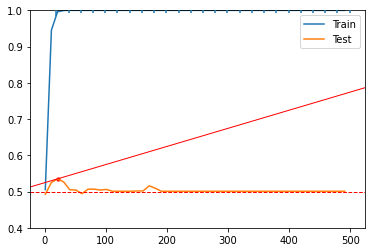

AT (21, 0.535, 0.3804) WITH 25 ITERATIONS IN 446.7029904127121 SECONDS : 3.7799253108940767
__main__.SVM_RFE_W_STEP - 00:07:35.036420500
poly 9 0.5


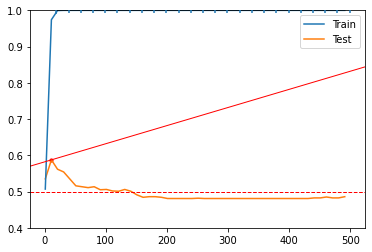

AT (11, 0.5875, 0.33440000000000003) WITH 25 ITERATIONS IN 450.63906466960907 SECONDS : 6.227259487040854
__main__.SVM_RFE_W_STEP - 00:07:39.106382100
poly 9 0.6


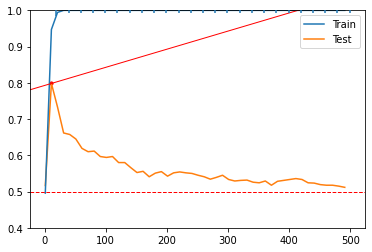

AT (11, 0.7983333333333333, 0.16573333333333332) WITH 25 ITERATIONS IN 445.02249642213184 SECONDS : 3.62749221596896
__main__.SVM_RFE_W_STEP - 00:07:32.975008300
poly 9 0.7


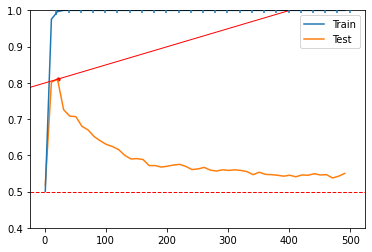

AT (21, 0.8099999999999999, 0.16040000000000004) WITH 25 ITERATIONS IN 440.93950108687085 SECONDS : 2.6032443851126352
__main__.SVM_RFE_W_STEP - 00:07:28.622915700
poly 9 0.8


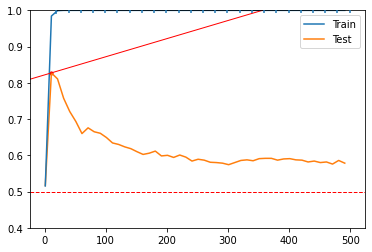

AT (11, 0.8275, 0.14239999999999997) WITH 25 ITERATIONS IN 449.1352596282959 SECONDS : 45.198795030483005
__main__.SVM_RFE_W_STEP - 00:07:40.176294700
poly 9 0.9


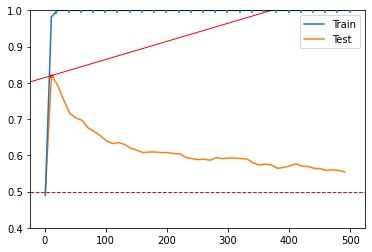

AT (11, 0.82, 0.14840000000000003) WITH 25 ITERATIONS IN 468.9459484020869 SECONDS : 0.2400918406683827
__main__.SVM_RFE_W_STEP - 00:07:56.764969300


In [9]:
SVM_RFE_W_STEP(20, 0.1, 9, 'poly')
SVM_RFE_W_STEP(20, 0.2, 9, 'poly')
SVM_RFE_W_STEP(20, 0.3, 9, 'poly')
SVM_RFE_W_STEP(20, 0.4, 9, 'poly')
SVM_RFE_W_STEP(20, 0.5, 9, 'poly')
SVM_RFE_W_STEP(20, 0.6, 9, 'poly')
SVM_RFE_W_STEP(20, 0.7, 9, 'poly')
SVM_RFE_W_STEP(20, 0.8, 9, 'poly')
SVM_RFE_W_STEP(20, 0.9, 9, 'poly')

poly 7 0.9


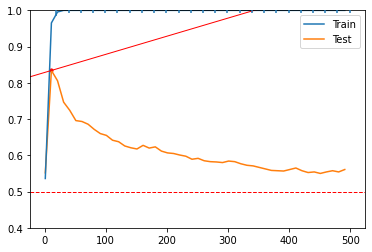

AT (11, 0.8341666666666666, 0.1370666666666667) WITH 25 ITERATIONS IN 441.51194139321643 SECONDS : 1.0353156839687172
__main__.SVM_RFE_W_STEP - 00:07:29.261005900
poly 8 0.9


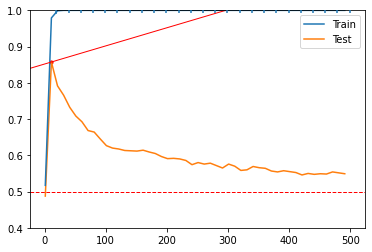

AT (11, 0.8574999999999999, 0.11840000000000006) WITH 25 ITERATIONS IN 451.0594135920207 SECONDS : 41.7661197674831
__main__.SVM_RFE_W_STEP - 00:07:41.843731300


In [10]:
SVM_RFE_W_STEP(20, 0.9, 7, 'poly')
SVM_RFE_W_STEP(20, 0.9, 8, 'poly')

poly 6 0.5


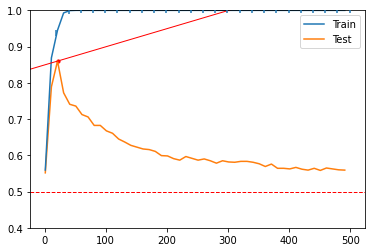

AT (21, 0.86, 0.12040000000000002) WITH 25 ITERATIONS IN 115.49306432406108 SECONDS : 5.9970946948943675
__main__.SVM_RFE_W_STEP - 00:02:05.392350000


In [18]:
SVM_RFE_W_STEP(20, 0.5, 6, 'poly')